# Altersregression anhand von Bildern

In diesem Notizbuch richten Sie Regressionsmodelle ein, die eine gaußsche bedingte Wahrscheinlichkeitsverteilung ausgeben.
Sie modellieren die bedingte Wahrscheinlichkeitsverteilung $p(y|x)$ als Normalverteilung.

## Datensatz
Sie arbeiten mit dem [UTKFace-Datensatz](https://susanqq.github.io/UTKFace/). Dieser umfasst eine große Altersspanne (von 0 bis 116 Jahren). Der Datensatz besteht aus über 20.000 Gesichtsbildern mit Angaben zu Alter, Geschlecht und ethnischer Zugehörigkeit. Die Daten sind bereits vorverarbeitet und neu skaliert (80 x 80 Pixel), sodass Sie damit arbeiten können. Sie verwenden nur die Informationen zu Alter und Bild.

## GPU Nutzung
Für dieses Notebook ist es besser, die GPU zu verwenden. Wenn Sie Colab verwenden, können Sie den Laufzeittyp im Menü ändern: Laufzeit -> Laufzeittyp ändern -> Hardwarebeschleuniger -> GPU.

Auf einer Windows WSL-Installation mit installiertem CUDA Toolkit sollte die GPU automatisch verwendet werden.

___

## Daten und Einstellungen
Gehen Sie das Notizbuch durch und versuchen Sie, den Code zu verstehen. Der Code ist bereits ziemlich vollständig, füllen Sie die Zellen mit (🔧 IHRE AUFGABE) aus.

### Einstellungen

Eine negative Nummer bei `EPOCHS` lägt die trainierten Gewichte 

In [3]:
EPOCHS = -100   #Change this to smaller number for testing, negative means load the weights from dropbox (only for JAX)

# Note: only tested for JAX backend
BACKEND = 'JAX' #Change this to 'JAX' or 'TORCH' 

In [4]:
### Running on Colab
import sys
import time
#IN_COLAB = 'google.colab' in sys.modules
IN_COLAB = False
print(f"Running on Colab: {IN_COLAB}")

Running on Colab: False


### Backend Einstellen

In [6]:
import os
################## Keras with PyTorch Backend ################
if (BACKEND == 'TORCH'):
  # Set Keras backend to PyTorch
  # os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" #Needed on MAC to avoid MPS error (22 Nov 2024)
  os.environ["KERAS_BACKEND"] = "torch" # Before importing Keras!
  import torch
  from torch.distributions import Normal
  cuda_available = torch.cuda.is_available()
  cuda_version = torch.version.cuda if cuda_available else "N/A"
  print(f"CUDA Available: {cuda_available}")
  print(f"CUDA Version: {cuda_version}")

################## Keras with JAX Backend ################
if (BACKEND == 'JAX'):
  if (IN_COLAB): #Currently December 2024 numpyro needs to be installed manually
    start_time = time.time()
    %pip install numpyro
    end_time = time.time()
    print(f"Time taken to install numpyro: {(end_time - start_time):.2f} seconds")
  # Set Keras backend to JAX
  os.environ["KERAS_BACKEND"] = "jax" # Before importing Keras!
  import jax
  from jax import random
  from numpyro import distributions as dist
  import jax.numpy as jnp
  print(f"jax.__version__ {jax.__version__}")
  cuda_available = any(device.platform == 'gpu' for device in jax.devices())
  # Attempt to get CUDA version info (platform_version often includes CUDA info)
  print(f"jax.devices() {jax.devices()}")
  # get GPU Name
  if (cuda_available):
    print(f"jax.devices()[0].device_kind {jax.devices()[0].device_kind}")
    

import keras
print(keras.__version__)
print(f"Keras version: {keras.__version__}")
print(f"Backend: {keras.backend.backend()}")

jax.__version__ 0.8.2
jax.devices() [CpuDevice(id=0)]
3.13.0
Keras version: 3.13.0
Backend: jax


### Import relevanter Bibliotheken und Einstellungen

In [4]:
##### We import Keras (after setting the backend)
from keras import layers, Input, Model
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, Input, Concatenate
import keras.backend as K


import numpy as np

import urllib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from tqdm.keras import TqdmCallback # train the model

### Datensatz laden und vorbereiten

In [5]:
if not os.path.isfile('X_faces.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/5m7nmebpjysqtus/X_faces.npy?dl=1",
    "X_faces.npy")
#!ls -lh X_face*

if not os.path.isfile('Y_age.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/flpyvgdqoatdw0g/Y_age.npy?dl=1",
    "Y_age.npy")
#!ls -lh Y*

In [6]:
X=np.load("X_faces.npy")
Y=np.load("Y_age.npy")

### Splitting the data into train, val and test dataset

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=201)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=34)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10642, 80, 80, 3)
(5242, 80, 80, 3)
(7824, 80, 80, 3)


### Looking at a few image samples

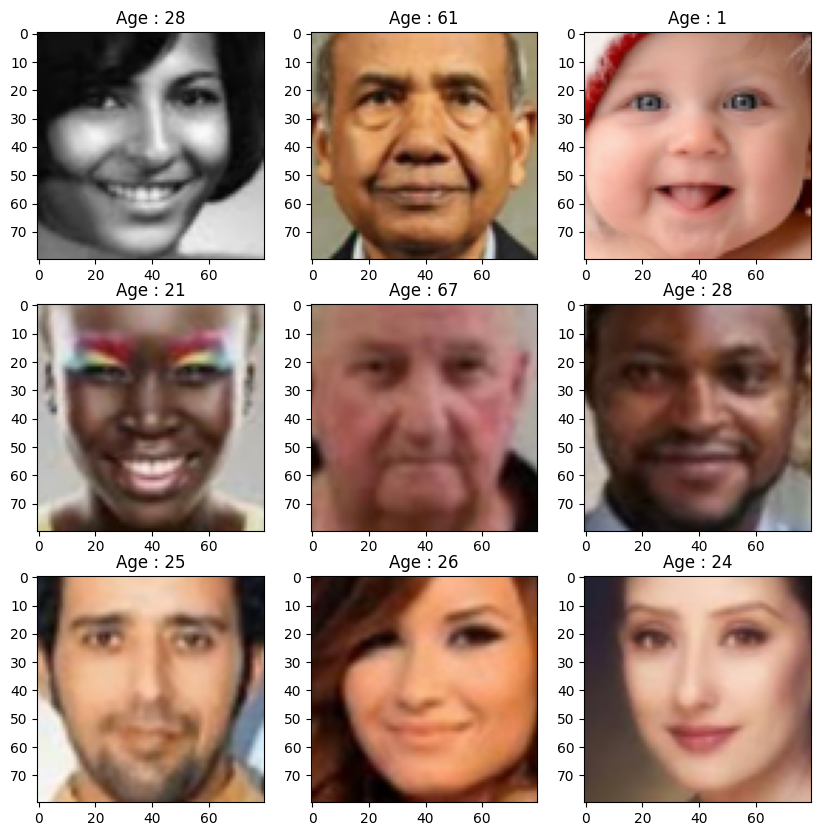

In [8]:
plt.figure(figsize=(10,10))
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i])
    plt.title("Age : "+ str(y_train[i]))

### Normalize the data

In [9]:
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10642, 80, 80, 3)
(5242, 80, 80, 3)
(7824, 80, 80, 3)


### Looking at the age distribution

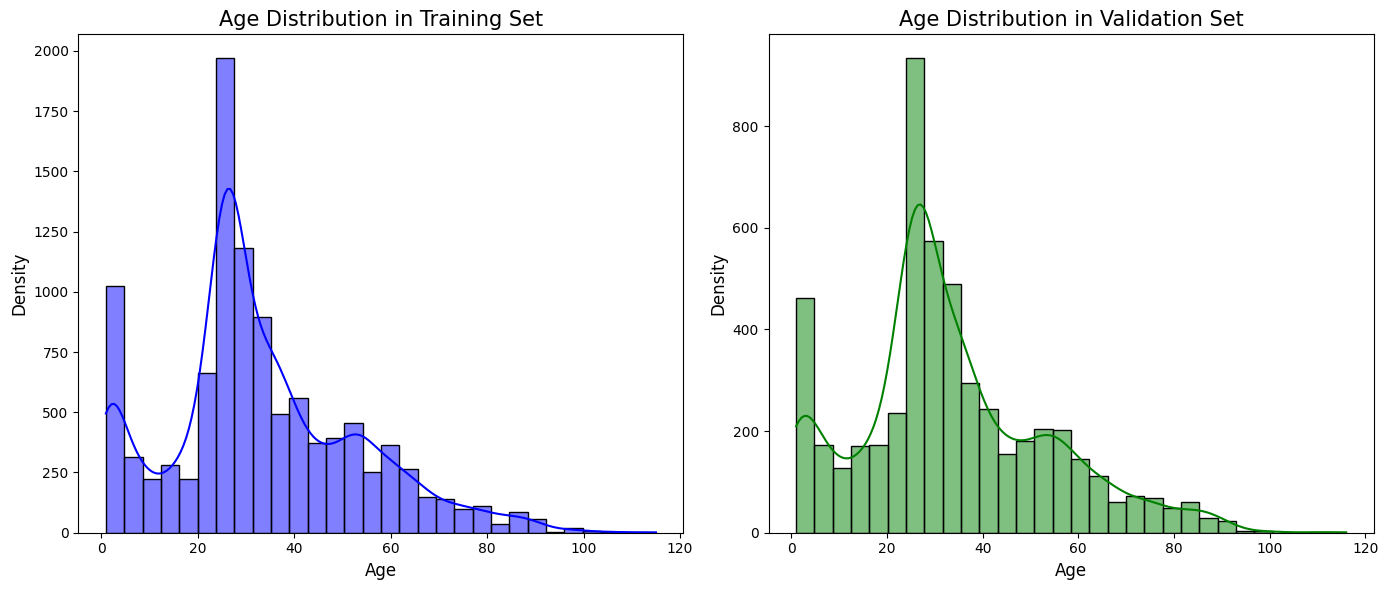

In [10]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(y_train, bins=30, kde=True, color='blue')
plt.title("Age Distribution in Training Set", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.subplot(1,2,2)
sns.histplot(y_val, bins=30, kde=True, color='green')
plt.title("Age Distribution in Validation Set", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.tight_layout()
plt.show()

## 🔧 **Übung 1:** Implementierung eines naiven Modells

Verwenden Sie ein naives Modell, das einfach eine Gaußsche Verteilung vorhersagt, ohne die Bilder zu verwenden. Um die Aufgabe zu lösen, müssen Sie die Werte für $\mu$ und $\sigma$ der Gaußschen Verteilung $N(\mu,\sigma)$ schätzen. 

### i) Schätzung von $\mu$ und $\sigma$
Sie sollten $\hat{\mu} \approx 33,14$ und $\hat{\sigma} \approx 19,81$ erhalten.

### ii) Berechnen Sie die NLL für den Testsatz.

#### Ziel der Aufgabe

Ziel der Aufgabe ist ein neuronales Netz zu bauen, das für ein Gesicht ($x$) $$p(y \mid x,w)$$ modelliert, wobei:
- $y$: Alter (kontinuierlicher Zahlenwert)
- $p(y \mid x)$: Normalverteilung

Unter der gegebenen Verteilung ergibt sich daher:
$$y \mid x \sim \mathcal{N}(\mu(x), \sigma(x)$$

Das Netz gibt also nicht das Alter aus sondern eine Verteilung über das Alter

Die Normalverteilung benötigt wie gezeigt zwei Parameter:
- Mittel/Erwartungswert: $\mu(x) \in \mathbb{R}$
- Standardabweichung: $\sigma(x) \gt 0$

In [11]:
import numpy as np
import jax.numpy as jnp
import keras

# Inspect Keras/TensorFlow versions and backend
print("KERAS_BACKEND env:", os.environ.get("KERAS_BACKEND"))
print("keras.__version__:", getattr(keras, "__version__", "unknown"))
try:
    from keras.backend import backend as kb_backend
    print("keras.backend.backend():", kb_backend())
except Exception as e:
    print("keras.backend.backend() unavailable:", e)
try:
    import tensorflow as tf
    print("tensorflow.__version__:", tf.__version__)
except Exception as e:
    print("TensorFlow import failed:", e)

KERAS_BACKEND env: jax
keras.__version__: 3.13.0
keras.backend.backend(): jax
tensorflow.__version__: 2.20.0


#### Parameter umwandeln
Das Netzwerk soll die Parameter einer bedingten Wahrscheinlichkeit unter Nutzung der Normal- bzw. Gaußverteilung ermitteln.

Das Netzwerk gibt hierbei aber wie in der Vorlesung behandelt in der Regel Werte $\in [-\infty, \infty]$ aus. Sigma ($\sigma$) muss per Definition aber ein Wert $\gt 0$ sein. 

Die folgende Funktion `output_to_gaussian_distribution` nimmt dabei die Netzwerkausgabe und wandelt den unbegrenzten Sigma-Wert mittls `softplus` um (siehe Vorlesung 7 Seite 27) so das gilt: $$\sigma \gt 0$$

In [12]:
def output_to_gaussian_distribution(out):
    """
    out[:, 0] -> mean μ(x) ∈ ℝ
    out[:, 1] -> raw_sigma ∈ ℝ
    """
    mean = out[:, :1]
    raw_sigma = out[:, 1:]

    # enforce positivity of sigma
    sigma = jax.nn.softplus(raw_sigma) + 1e-6

    return dist.Normal(mean, sigma)


#### Netzwerkdefinition

Wie in der Aufgabenbeschreibung dargestellt soll das Netz nicht die X-Daten aus den Trainingsdaten sondern nur die Y-Labels. Daher wird hier noch ein neuer `input` definiert der dem Modell als Input übergeben wird (Achtung: Beim *fitten* wird nachher dennoch `X_train` übergeben, dies hat aber kein Einfluss da diese im Modell nicht genutzt werden)

Wie eingangs beschrieben muss das Netzwerk zur Ausgabe von $\mu(x)$ und $\sigma(x)$ **zwei Schichten haben** (siehe hierzu auch Vorlesung 07 Seite 26)



In [13]:
inputs = keras.Input(shape=(80, 80, 3))

x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)

# two separate heads
mean = keras.layers.Dense(1, activation="linear")(x)
raw_sigma = keras.layers.Dense(1, activation="linear")(x)

outputs = keras.layers.Concatenate()([mean, raw_sigma])

model = keras.Model(inputs=inputs, outputs=outputs)


#### Gauß-Negative-Log-Likelihood

Die **Normal- bzw. Gaußverteilung** ist definiert als: 
$$p(y \mid \mu, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}} e^{- \left(\frac{(y - \mu)^2}{2\sigma^2}\right)}$$

Für ein einzelnes Datenpaar $(x_i, y_i)$ aus den Trainingsbeispielen lautet die **Likelihood** also wie folgt:
$$\mathcal{L_i} = p(y_i \mid x_i) = \frac{1}{\sigma(x_i) \sqrt{2 \pi}} e^{- \left(\frac{(y_i - \mu(x_i))^2}{2\sigma(x_i)^2}\right)}$$

Da die Likelihood für den gesamten Datensatz aus vielen Produkten kleiner Wahrscheinlichkeiten besteht was numerisch instabil sein kann nutzen wir auch hier die **Log-Likelihood**. Diese ist definiert als:
$$\log \mathcal{L} = \sum_{i =1}^N \log p(y_i \mid x_i)$$

Anschließend wird die oben gezeigte Definition der Gaußdichte in die NLL eingesetzt:
$$\log p(y \mid \mu, \sigma) = \log \left( \frac{1}{\sigma \sqrt{2 \pi}} \right) + \log \left(e^{- \left(\frac{(y - \mu)^2}{2\sigma^2}\right)} \right)$$

Da der Logarithmus von ner e-Funktion hoch irgendwas halt einfach nur der hochteil ist ($\log(e^a) = a$) und ein Produkt im Logarithmus auch als Summe einzelner Logarithmen geschrieben werden kann ($\log(a \cdot b) = \log(a) + \log(b)$) lässt sich dies wie folgt vereinfachen (Vorzeichenwechsel wegen Kehrwert!):
$$\log p(y \mid \mu, \sigma) = -\log \sigma -(\sqrt{2\pi}) - \log \frac{(y - \mu)^2}{2\sigma^2}$$

Da wir den Negative-Log-Likelihood wollen können wir die Vorzeichen dann aber alle nochmal drehen. Zudem kann der Term $\log(\sqrt{2\pi})$ weg gelassen werden, da dieser nur konstante Werte enthält und nicht von $\sigma$ bzw. $\mu$ abhängt. Dies ergibt die **finale NLL** mit: 
$$\boxed{\text{NLL} = \log \sigma + \frac{(y - \mu)^2}{2\sigma^2}}$$

##### Implementierung

Die Umsetztung erfolgt mittels `numpyro` Methode (siehe hierzu auch [GitHub](https://github.com/pyro-ppl/numpyro/blob/master/numpyro/distributions/continuous.py#L2477))

```python
def log_prob(self, value: ArrayLike) -> ArrayLike:
        normalize_term = jnp.log(jnp.sqrt(2 * jnp.pi) * self.scale)
        value_scaled = (value - self.loc) / self.scale
        return -0.5 * value_scaled**2 - normalize_term
```

Zudem wird wie in Vorlesung 07 auf Seite 21 gezeigt noch mittels `jnp.mean` normalisiert (*"The constant factor 1/N is to remove dependence of batchsize"*)

In [14]:
def negative_log_likelihood(y_true, output):
    gaussian = output_to_gaussian_distribution(output)
    return -jnp.mean(gaussian.log_prob(y_true))

#### Interpretation der Terme
##### Fehlerterm
$$\frac{(y - \mu)^2}{2\sigma^2}$$
- großer Fehler = großer Loss
- großes $\sigma$ = Feler wird abgeschwächt
##### Regularisierungsterm
$$\log \sigma$$
- bestraft große Unsicherheit
- verhindert triviale Lösung $\sigma \rightarrow \infty$

#### Netzwerktraining
Anschließend kann das Netzwerk traininert werden

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=negative_log_likelihood
)

model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    validation_split=0.1
)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 7.0704 - val_loss: 4.5597
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4.5423 - val_loss: 4.4871
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4.5416 - val_loss: 4.4714
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.5172 - val_loss: 4.5320
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.5384 - val_loss: 4.5279
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.5322 - val_loss: 4.4711
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.5120 - val_loss: 4.5227
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.5144 - val_loss: 4.5086
Epoch 9/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.5098 - val_loss: 4.6882
Epoch 10/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.5045 - val_loss: 4.5536
Epoch 11/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.5049 - val_loss: 4.4836
Epoch 12/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/s

In [ ]:
output_test = model(X_test)
dist_test = output_to_gaussian_distribution(output_test)

mean_pred = np.mean(dist_test.loc)
sigma_pred = np.mean(dist_test.scale)

print("Durchschnittlicher vorhergesagter Mittelwert μ:", mean_pred)
print("Durchschnittliche vorhergesagte Standardabweichung σ:", sigma_pred)
#y_pred = model.predict(X_test.copy())
#print("NLL: ", negative_log_likelihood(y_pred.copy, output_test))
#NLL(y_pred.copy(), y_test.copy())


Durchschnittlicher vorhergesagter Mittelwert μ: 30.046385
Durchschnittliche vorhergesagte Standardabweichung σ: 6.4384983e+12
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'jaxlib._jax.ArrayImpl'

***

### ⚠️ Daten für das Backend vorbereiten ⚠️
Beachten Sie, dass die Umformung äußerst wichtig ist. Dadurch wird die Form von y von $(B,)$ zu $(B,1)$ zu einer Form von $(B,)$ was zu seltsamen Broadcast-Fehlern führt. Um dies zu überprüfen, entfernen Sie die Umformung und trainieren Sie erneut.

In [17]:
#We only need float32
X_train = np.array(X_train,dtype="float32")
X_val = np.array(X_val,dtype="float32")
X_test = np.array(X_test,dtype="float32")

##### NOTE THE RESHAPE IS EXTREMLY IMPORTANT ####
y_train = np.array(y_train,dtype="float32").reshape(-1,1) #⚠️ w/o reshape no training beyond naive model
y_val = np.array(y_val,dtype="float32").reshape(-1,1)     #⚠️
y_test = np.array(y_test,dtype="float32").reshape(-1,1)   #⚠️

if (K.backend() == 'torch'):
  X_train = torch.tensor(X_train).float()
  X_val = torch.tensor(X_val).float()
  X_test = torch.tensor(X_test).float()
  y_train = torch.tensor(y_train).float()
  y_val = torch.tensor(y_val).float()
  y_test = torch.tensor(y_test).float()

print(X_train.mean())
print(X_val.mean())
print(X_val.mean())

print(y_train.shape) #Need to have the last dimension of ,1

0.47795627
0.47746995
0.47746995
(10642, 1)


### Ausgabe von NN zur Gaußschen Verteilung

Die Ausgabe NN hat die Form (B, 2) mit der ersten Dimension. Die letzten beiden Dimensionen codieren den Mittelwert und den Logarithmus der Standardabweichung der Gaußschen Verteilung.

In [18]:
# Wrapper function to convert model output to a PyTorch Normal distribution
if (K.backend() == 'torch'):
  print('Using PyTorch specific code')
  from torch import nn
  import torch
  from torch.distributions import Normal

  @staticmethod
  def output_to_gaussian_distribution(output):
      mean = output[:, :1]
      log_variance = output[:, 1:]
      scale = torch.exp(log_variance)  # Ensure positive scale
      return torch.distributions.Normal(loc=mean, scale=scale)

if (K.backend() == 'jax'):
  print('Using JAX specific code')
  from numpyro import distributions as dist

  @staticmethod
  def stable_softplus(x):
    return jnp.where(x > 20, x, jnp.log(1 + jnp.exp(x)))

  @staticmethod
  def output_to_gaussian_distribution(out):
      mean = out[:, :1]       # first column is mean
      log_sd = out[:, 1:]    # last column is log variance
      #scale = 1e-3 + stable_softplus(0.05 * out[:, 1:])  # Apply stable softplus to log scale
      scale = jnp.exp(log_sd)
      return dist.Normal(mean, scale)

def NLL(y_true, output):
  dist = output_to_gaussian_distribution(output)
  return -dist.log_prob(y_true).mean()

Using JAX specific code


### Untersuchung der ausgegebenen Verteilung und Erklärung eines subtilen Fehlers

Eine detaillierte Beschreibung des Fehlers finden Sie unter: https://github.com/tensorchiefs/dl_keras3/blob/main/notebooks/probabilistic_modelling/batching_gradient_problem.ipynb

out.shape (3, 2)
(3,)
1.7281334


👎 shape of y(3,)
grad of NLL [-0.02777778 -0.02777778 -0.02777778]


👍 shape of y(3, 1)
grad of NLL [[ 0.        ]
 [ 0.        ]
 [-0.08333334]]


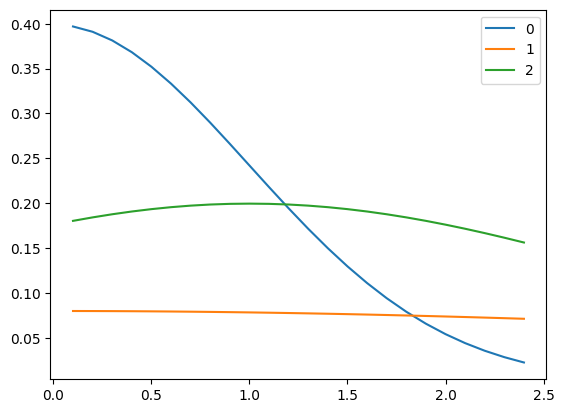

In [19]:
out = np.array([
    [0,np.log(1)],
    [0,np.log(5)],
    [1,np.log(2)]
])

xs = np.arange(0.1,2.5,0.1)

if (K.backend() == 'torch'):
  print('Using PyTorch specific code')
  out = torch.tensor(out)
  xs = torch.tensor(xs)

print(f"out.shape {out.shape}")
outdist = output_to_gaussian_distribution(out)
outdist.mean

outdist.log_prob(xs).shape
for i in range(3):
  plt.plot(xs, np.exp(outdist.log_prob(xs))[i], label=str(i))
plt.legend()
#plt.show()

yy = np.zeros((3))
if (K.backend() == 'torch'):
  yy = torch.tensor(yy)

print(yy.shape)
print(NLL(yy, out))

if (K.backend() == 'jax'):
  print("\n")
  print(f"👎 shape of y{yy.shape}\ngrad of NLL {jax.grad(NLL)(yy, out)}")
  yy = yy.reshape(-1,1)
  print("\n")
  print(f"👍 shape of y{yy.shape}\ngrad of NLL {jax.grad(NLL)(yy, out)}")
  yy = np.zeros((3,))
  jax.grad(NLL)(yy, out)

## Ein Regressionsmodell mit flexibler Varianz fitten
In den nächsten Zellen definieren und passen Sie erneut ein Modell für die Gesichtsbilder an. Sie verwenden ein CNN, um den Mu-Parameter einer gaußschen bedingten Wahrscheinlichkeitsverteilung zu modellieren, aber dieses Mal ist Sigma nicht für alle Eingaben konstant. Jedes Bild kann ein anderes Sigma haben. Für den Verlust verwenden wir die NLL.

In [20]:
kernel_size = (3, 3)
pool_size = (2, 2)
input1 = Input(shape=(80,80,3))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(input1)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Flatten(name = 'bef_split')(x)

# One HEAD
#x = Dense(2*500, activation="relu")(x)
#x = Dropout(0.3)(x)
#x = Dense(2*50, activation="relu")(x)
#x = Dropout(0.3)(x)
#mean_and_sd_layer = Dense(2)(x)

#### TWO HEAD
##### SIGMA HEAD
x_sd = Dense(500, activation="relu")(x)
x_sd = Dropout(0.3)(x_sd)
x_sd = Dense(50, activation="relu")(x_sd)
x_sd = Dropout(0.3)(x_sd)
x_sd = Dense(1)(x_sd)
### MEAN_HEAD
x_mu = Dense(500, activation="relu")(x)
x_mu = Dropout(0.3)(x_mu)
x_mu = Dense(50, activation="relu")(x_mu)
x_mu = Dropout(0.3)(x_mu)
x_mu = Dense(1)(x_mu)
### Concatinate
mean_and_sd_layer = Concatenate()([x_mu, x_sd])


model_flex = Model(inputs=input1, outputs=mean_and_sd_layer)
model_flex.compile(keras.optimizers.Adam(), loss=NLL)
model_flex.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 80, 80, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 80, 80,    │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 40,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 40, 40,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 40, 40,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 20, 20,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 20, 20,    │      9,248 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 20, 20,    │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 10, 10,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bef_split (Flatten) │ (None, 3200)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 500)       │  1,600,500 │ bef_split[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 500)       │  1,600,500 │ bef_split[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 500)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 500)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 50)        │     25,050 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 50)        │     25,050 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 50)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         51 │ dropout_3[0][0] 

 Total params: 3,286,354 (12.54 MB)

 Trainable params: 3,286,354 (12.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
if (EPOCHS > 0):
  history=model_flex.fit(X_train, y_train,
                      epochs=EPOCHS,
                      verbose=0,
                      validation_data=(X_val, y_val),
                      callbacks=[TqdmCallback(verbose=1)]
                    )
  model_flex.save_weights('model_flex.weights.h5')
  # Save history files
  with open('history.pkl', 'wb') as f:
      pickle.dump(history.history, f)
  plt.plot(history.history['loss'], label = 'Training Loss')
  plt.plot(history.history['val_loss'], label = 'Validation Loss')
  plt.axhline(y=nll_naive, color='r', linestyle='--', label='Naive NLL')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.ylim(0, 7)
  plt.legend()
  plt.show()
else:
    print("Downloading weights ...")
    import requests
    # Define the URL and the local file path
    url = 'https://www.dropbox.com/scl/fi/7lgbkld4u55b70kt5rwqz/model_flex.weights.h5?rlkey=oxf9g4cyfit3pjuu71t2sltlb&dl=1'
    local_file = 'model_flex.weights.h5'

    # Check if the file already exists
    if not os.path.exists(local_file):
        # Download the file if it does not exist
        response = requests.get(url)
        with open(local_file, 'wb') as f:
            f.write(response.content)

    # Load the weights from the local file
    model_flex.load_weights(local_file)

#### Sehen Sie sich den vorhergesagten Mittelwert und das vorhergesagte Sigma der CPD im Testsatz an.

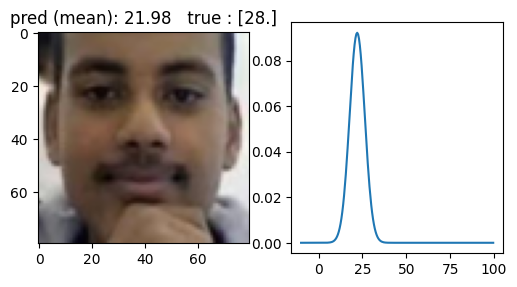

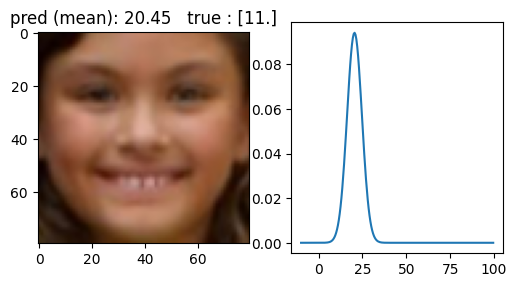

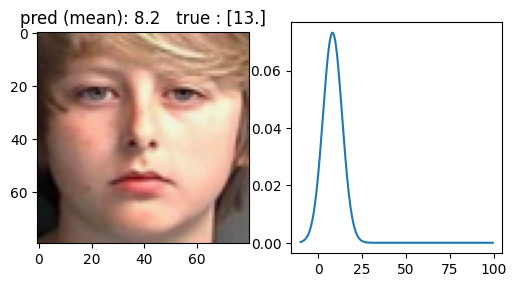

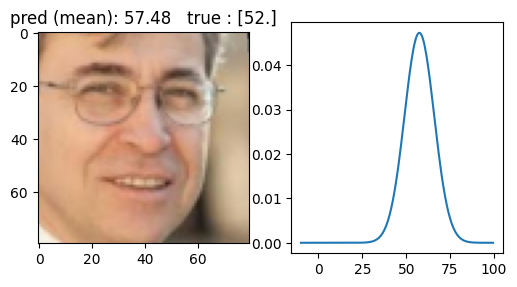

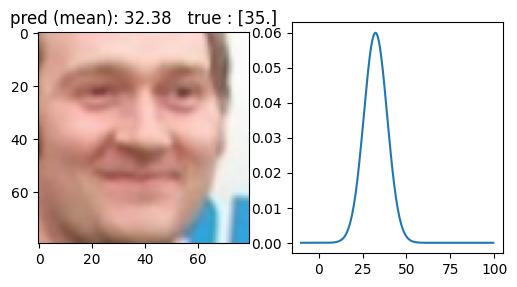

In [22]:
ages = np.arange(-1,100,0.5)

for i in range(0,5):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(X_test[i])

    mu_sigma = model_flex(X_test[i:i+1])
    mu = mu_sigma[0, 0]
    sigma = np.exp(mu_sigma[0, 1])

    plt.title("pred (mean): "+ str(round(float(mu), 2)) +
            "   true : "+ str(y_test[i]))
    d = dist.Normal(loc=mu, scale=sigma)
    plt.subplot(1,2,2)
    ys = jnp.arange(-10,100,0.5)
    plt.plot(ys, np.exp(d.log_prob(ys)))
    plt.show()

# 🔧 Übung 2 (Berechnung der Modellleistung)

Berechnen Sie die NLL für den Testsatz. Schreiben Sie dazu eine Funktion, die die API einer Punktzahl hat. Die Funktion sollte die beobachteten/wahren `y_observed`-Werte und die vorhergesagte CPD $p_{\tt{pred}}(y|x)$ als Eingabe (genannt `py_given_x`) nehmen und die NLL zurückgeben. Hier ist der Kern der Funktion:

```python
def score(py_given_x, y_observed):
    # py_given_x: the predicted CPD as a tfp.distributions object
    # y_observed: the observed/true values
    # return: Score (lower is better forecast)
    # YOUR CODE HERE
```

Welche anderen Bewertungen/Kennzahlen könnten Sie zum Vergleich der Modelle verwenden, welche sollten Sie nicht verwenden?

Aus bestimmten Gründen muss das Netzwerk mithilfe der Funktion `output_to_gaussian_distribution` in eine Verteilung umgewandelt werden. Diese Funktion ist bereits im Notebook implementiert.

```python
def NLL(out_network, y):
    dist = output_to_gaussian_distribution(out_network)
    ... YOUR CODE HERE ...
```

## `score` Funktion
Die `score` Funktion wird wie zuvor implementiert

In [23]:
def score(py_given_x, y_observed):
  """
  """
  loss = -jnp.mean(py_given_x.log_prob(y_observed))
  return loss

### Negative-Log-Likelihood Funktion


In [24]:
def NLL(out_network, y):
    distributions = output_to_gaussian_distribution(out_network)
    return score(distributions, y)

In [25]:
y_pred = model_flex.predict(X_test.copy())
print(NLL(y_pred.copy(), y_test.copy()))

245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step
3.9899943


In [ ]:
dist_test_flex = output_to_gaussian_distribution(y_pred)

mean_pred_flex = np.mean(dist_test_flex.loc)
sigma_pred_flex = np.mean(dist_test_flex.scale)

print("Naives Modell: Durchschnittlicher vorhergesagter Mittelwert μ:", mean_pred)
print("Naives Modell: Durchschnittliche vorhergesagte Standardabweichung σ:", sigma_pred)
print("Bildbasiertes Modell: Durchschnittlicher vorhergesagter Mittelwert μ:", mean_pred_flex)
print("Bildbasiertes Modell: Durchschnittliche vorhergesagte Standardabweichung σ:", sigma_pred_flex)

Durchschnittlicher vorhergesagter Mittelwert μ: 30.046385
Durchschnittliche vorhergesagte Standardabweichung σ: 6.4384983e+12
Durchschnittlicher vorhergesagter Mittelwert μ: 32.62202
Durchschnittliche vorhergesagte Standardabweichung σ: 5.79726


***

# 🔧 Übung 3 (Sicherste Vorhersagen finden)

Finden Sie die 5 Personen aus dem Testsatz, bei denen das Modell die sichersten Vorhersagen trifft, und stellen Sie diese zusammen mit der vorhergesagten CPD grafisch dar.

In [26]:
log_variance = y_pred[:, 1:]
scale = jnp.exp(log_variance)
scales_with_index = [(i, x) for i, x in enumerate(scale)]
sorted_scales = sorted(scales_with_index, key=lambda x: x[1])[:5]

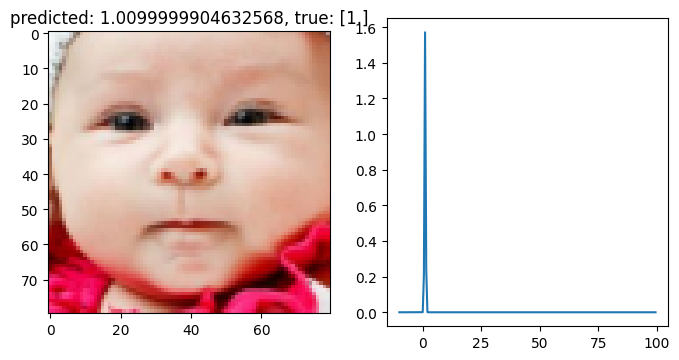

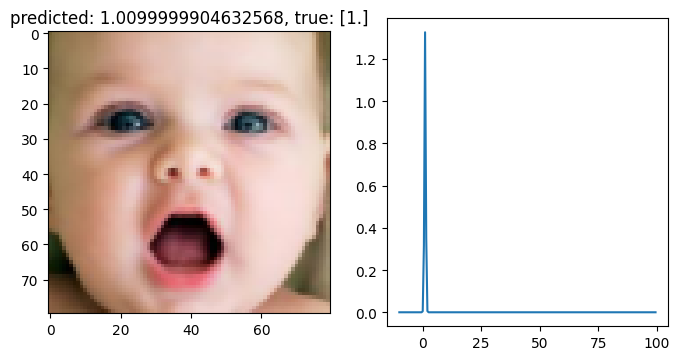

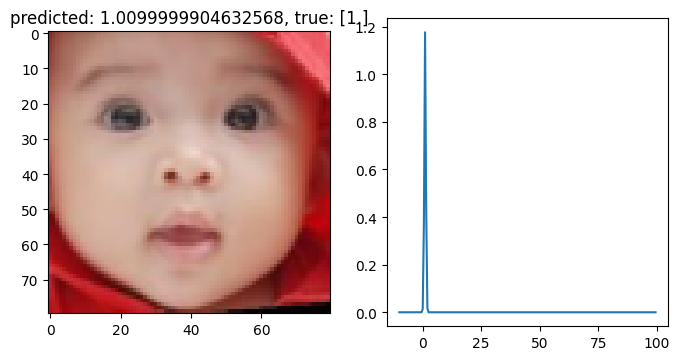

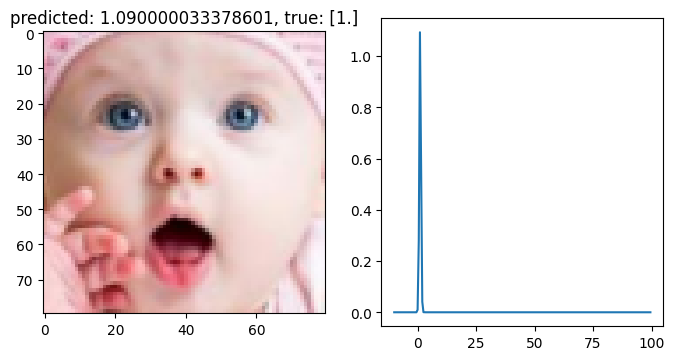

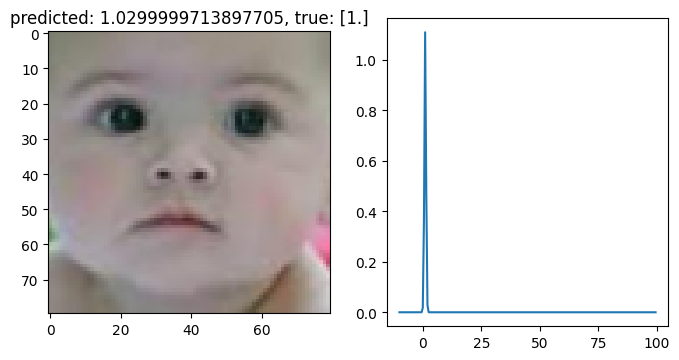

In [27]:
for x in sorted_scales:
    i = x[0]
    predicted_age = round(y_pred[i, 0], 2)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(X_test[i])
    plt.title(f"predicted: {predicted_age}, true: {y_test[i]}")
    d = dist.Normal(loc=predicted_age, scale=scales_with_index[i][1])
    plt.subplot(1,2,2)
    ys = jnp.arange(-10,100,0.5)
    plt.plot(ys, np.exp(d.log_prob(ys)))
    plt.show()

***

# 🔧 Übung 4 (PIT-Histogramm)

Erstellen Sie ein sogenanntes PIT-Histogramm (Probability Integral Transform), um zu überprüfen, ob das Modell kalibriert ist. Berechnen Sie dazu die Werte der kumulativen Verteilungsfunktion (CDF) der vorhergesagten Verteilung, die bei den beobachteten Altersstufen ausgewertet wird. Zeichnen Sie dann ein Histogramm dieser Werte. Das Histogramm sollte gleichmäßig sein, wenn das Modell kalibriert ist. Beschreiben Sie Ihre Ergebnisse.


Hinweis: Sie können die Funktion `scipy.stats.norm.cdf` verwenden, um die CDF der Normalverteilung zu berechnen.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# mu, sigma aus deinem Modell (z.B. aus numpyro / keras)
# y_test: echte Alterswerte

# PIT-Werte berechnen
pit_values = norm.cdf(y_test, loc=[x[0] for x in y_pred], scale=scale)

# Histogramm plotten
plt.figure(figsize=(8, 6))
plt.hist(pit_values, bins=50, density=True, alpha=0.75, edgecolor='black')
plt.xlabel("PIT value")
plt.ylabel("Density")
plt.title("PIT Histogram")
plt.grid(True)
plt.show()


KeyboardInterrupt: 